In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import utils
from BayesModel import BFC, FC


In [43]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
train_loader, test_data = utils.get_nanotube_data(batch_size=200, scale=True)  # I have scaled data to have mean 0 and std 1 in all features.
X_test, Y_test = test_data


In [44]:
def train_model(*, model, optimer, train, device, epochs, enums=10):
    # model.to(device)
    pbar = tqdm(range(epochs))
    for epoch in pbar:
        for batch_idx, (x, y) in enumerate(train):
            # x, y = x.to(device), y.to(device)
            optimer.zero_grad()

            # sample batch enums times during training and average prediction before calculating loss
            outs = torch.zeros(enums, *y.size())
            for j in range(enums):
                outs[j] = model(x)
            
            pred = outs.mean(0)  # take average of all predictions of each datapoint as final prediction of that datapoint 
            kl = model.kl_reset(batches=len(train) * enums)  # normalise by number of batches and enums

            # nll + kl
            loss = -torch.distributions.Normal(pred, .1).log_prob(y).mean() + kl.to(device)
            loss.backward()
            optimer.step()
        pbar.set_description(f"total loss: {loss:.4f}, kl_loss: {kl:.4f}")

def train_model_freq(*, model, optimer, train, device, epochs):
    pbar = tqdm(range(epochs))
    loss_fn = torch.nn.MSELoss()
    for epoch in pbar:
        for batch_idx, (x, y) in enumerate(train):
            x, y = x.to(device), y.to(device)
            optimer.zero_grad()

            # was simpler to copy code than generalize for non-kl_divergence shit
            pred = model(x.to(torch.float))
            loss = loss_fn(pred, y.to(torch.float))
            
            loss.backward()
            optimer.step()
        pbar.set_description(f"total loss: {loss:.4f}")

In [45]:
plt.rcParams["figure.figsize"] = (20,5)
def plot_model_pred(model, Y_test, X_test, enums=10, single=False):
    Y_sample = Y_test.detach().numpy()

    # sample test data enums times and average to make a prediction
    Y_pred = torch.zeros(enums, *Y_test.size())
    for j in range(enums):
        Y_pred[j] = model(X_test)

    if single:  # Plots all the predictions of a single data point
        y1 = Y_pred.detach().numpy()[:, 1]
        Y = Y_sample[1]
        mean = y1.mean()
        x = np.linspace(0, 1, len(y1))
        plt.plot(x, y1, "bo", label="all preds for single datapoint")
        plt.plot(x, np.ones_like(x) * Y_sample[1], "r--", lw=5, label="true value")
        plt.plot(x, np.ones_like(x) * y1.mean(), "k--", lw=4, label="prediction mean")
        plt.plot(x, y1.mean() + np.ones_like(x) * y1.std(), "g--", lw=4, label="prediction std")
        plt.plot(x, y1.mean() - np.ones_like(x) * y1.std(), "g--", lw=4)
        plt.xlabel("Prediction count")
        plt.ylabel("Value")
        plt.title("All predictions for a single datapoint after training")
    else:  # Plot mean of all predictions for 40 datapoints, with error bounds
        mean = Y_pred.mean(0).detach().numpy()
        std = Y_pred.std(0).detach().numpy()
        print("std mean: ", std.mean())
        print("std std:", std.std())
        x = np.arange(len(Y_sample))
        xx = np.c_[x, x]
        interval = np.c_[mean - std, mean + std]
        mse_err = ((Y_sample - mean) ** 2).mean()
    
        plt.plot(Y_sample[:40], "bo", ms=8, label="target")
        plt.plot(mean[:40], "ro", ms=4, label="mean")
        plt.plot(xx[:40], interval[:40], "go", ms=4, label="1 sigma")
        plt.title(f"Total MSE on test data: {mse_err}")
        plt.xlabel("Datapoints")
        plt.ylabel("Value")
    plt.legend()
    plt.show()

def plot_model_pred_freq(model, Y_test, X_test):
    Y_sample = Y_test.detach().numpy()
    Y_pred_sample = model(X_test.to(torch.float)).detach().numpy()

    mse_err = ((Y_sample - Y_pred_sample) ** 2).mean()
    plt.plot(Y_sample[:100], "bo-", ms=8, label="target")
    plt.plot(Y_pred_sample[:100], "ro--", ms=4, label="prediction")
    plt.title(f"Total MSE on test data: {mse_err}")
    plt.legend()
    plt.show()

In [53]:
# use exactly same parameters for two models
net = BFC(features=7, classes=1, hiddens=[20, 20], nonlin="ReLU", prior={"dist": "gauss", "params": {"mean": 0, "std": 0.1}})
optimizer = torch.optim.AdamW(net.parameters(), lr=0.001)

fet = FC(features=7, classes=1, hiddens=[20, 20], nonlin="ReLU")
foptimizer = torch.optim.AdamW(fet.parameters(), lr=0.001)

In [106]:
train_model(model=net, optimer=optimizer, train=train_loader, device=device, epochs=10, enums=2)

  0%|          | 0/10 [00:00<?, ?it/s]

In [100]:
train_model_freq(model=fet, optimer=foptimizer, train=train_loader, device=device, epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

In [101]:
# layer = net.layers[0]
# plt.plot(layer.sample.training_data["wm"])
# plt.plot(layer
# .sample.training_data["ws"])


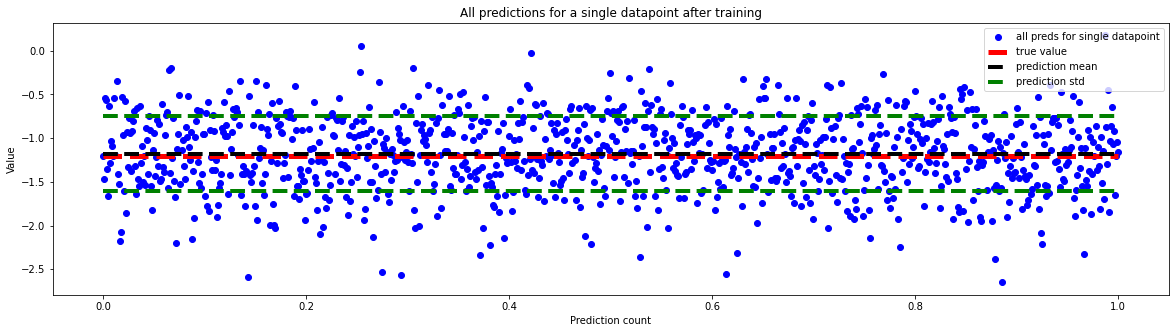

In [103]:
plot_model_pred(net, Y_test, X_test, enums=5000, single=True)

std mean:  0.42556143
std std: 0.02856735


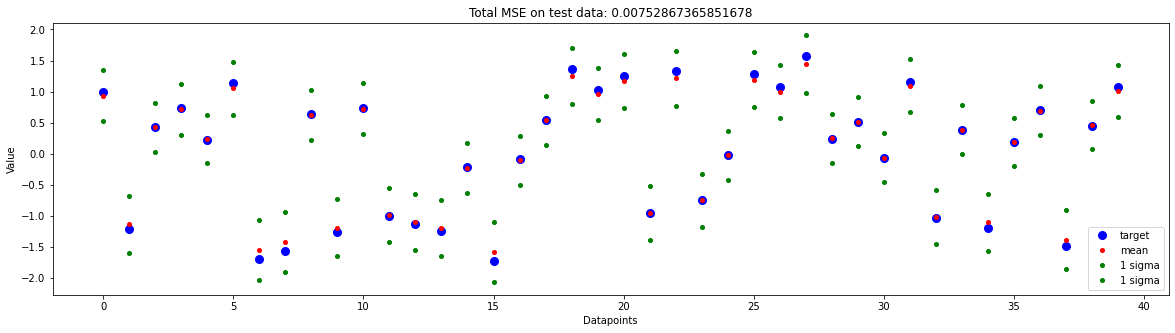

In [105]:
plot_model_pred(net, Y_test, X_test, enums=5000, single=False)

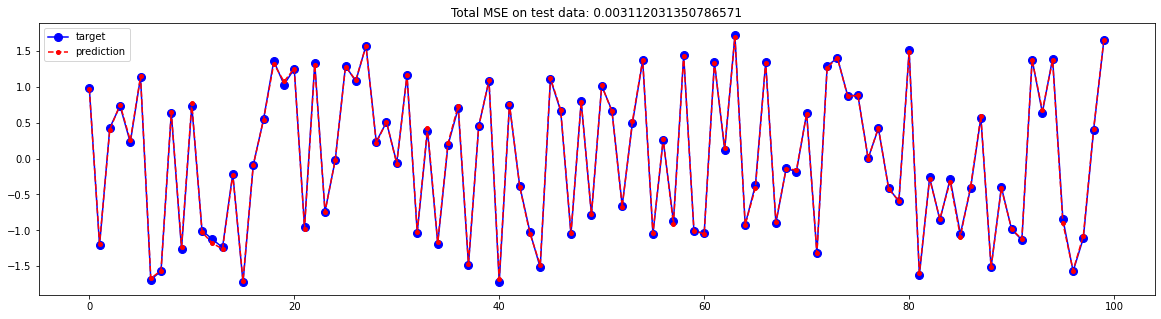

In [75]:
plot_model_pred_freq(fet, Y_test, X_test)


In [51]:
for layer in net.layers:
    if hasattr(layer, "sample"):
        print(layer.sample.weight_mean.mean(), layer.sample.weight_mean.std())
        print(layer.sample.weight_rho.mean(), layer.sample.weight_rho.std())
        print(layer.sample.bias_mean.mean(), layer.sample.bias_mean.std())
        print(layer.sample.bias_rho.mean(), layer.sample.bias_rho.std())
        print()
        print()

tensor(-0.0029, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor(0.1600, dtype=torch.float64, grad_fn=<StdBackward0>)
tensor(-2.6120, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor(0.1095, dtype=torch.float64, grad_fn=<StdBackward0>)
tensor(0.1251, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor(0.0697, dtype=torch.float64, grad_fn=<StdBackward0>)
tensor(-0.0089, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor(0.0679, dtype=torch.float64, grad_fn=<StdBackward0>)


tensor(0.0246, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor(0.1480, dtype=torch.float64, grad_fn=<StdBackward0>)
tensor(-2.6678, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor(0.1078, dtype=torch.float64, grad_fn=<StdBackward0>)
tensor(0.0415, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor(0.0471, dtype=torch.float64, grad_fn=<StdBackward0>)
tensor(-0.0272, dtype=torch.float64, grad_fn=<MeanBackward0>) tensor(0.0374, dtype=torch.float64, grad_fn=<StdBackward0>)


tensor(0.0193, dtype=to